In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV and Perform Basic Data Cleaning

In [3]:
df = pd.read_csv("cumulative.csv")
df = df.drop(columns=["rowid", "kepid", "kepoi_name", "kepler_name", "koi_pdisposition", "koi_score", "koi_tce_delivname"])
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Drop the null rows
df = df.dropna()
df.head()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,FALSE POSITIVE,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,FALSE POSITIVE,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,CONFIRMED,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Create a helper dictionary for quickly selecting subsets of columns from the dataframe

In [88]:

koi_flag_vars = [col for col in df.columns if 'flag' in col]
koi_err_vars = [col for col in df.columns if 'err' in col]
koi_num_vars = list(set(df.columns) - (set(koi_flag_vars).union(['koi_disposition', 'koi_tce_plnt_num'])))
koi_cat_vars = list(set(koi_flag_vars).union(['koi_tce_plnt_num']))

koi_dict = {
    'response': 'koi_disposition',
    'num_preds': koi_num_vars,
    'cat_preds': koi_cat_vars,
    'err_vars': koi_err_vars  
}

#koi_dict

# Consider the Data Structure
We find that there are 8744 rows and 41 columns (1 response and 40 potential predictors).  The predictors consist of transit properties which are best-fit model parameters and their errors, stellar parameters and their errors, threshold-crossing event information and additional KIC parameters.  Four of the predictors, the false-positive flags, are categorical (0-1 valued).  `koi_tce_plnt_num` is a discrete predictor.  The description of this predictor is vague; it may be an administrative variable lacking useful information.

The 20 err predictors come in pairs (one negative, one positive) for each of 10 predictors. 

There is redundant information in some of the predictors; for example, `koi_period_err2` is the negative value of `koi_period_err1`.  

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8744 entries, 0 to 9563
Data columns (total 41 columns):
koi_disposition      8744 non-null object
koi_fpflag_nt        8744 non-null int64
koi_fpflag_ss        8744 non-null int64
koi_fpflag_co        8744 non-null int64
koi_fpflag_ec        8744 non-null int64
koi_period           8744 non-null float64
koi_period_err1      8744 non-null float64
koi_period_err2      8744 non-null float64
koi_time0bk          8744 non-null float64
koi_time0bk_err1     8744 non-null float64
koi_time0bk_err2     8744 non-null float64
koi_impact           8744 non-null float64
koi_impact_err1      8744 non-null float64
koi_impact_err2      8744 non-null float64
koi_duration         8744 non-null float64
koi_duration_err1    8744 non-null float64
koi_duration_err2    8744 non-null float64
koi_depth            8744 non-null float64
koi_depth_err1       8744 non-null float64
koi_depth_err2       8744 non-null float64
koi_prad             8744 non-null float64

In [7]:
df.shape

(8744, 41)

In [9]:
df.describe()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8.744000e+03,8.744000e+03,8744.000000,8744.000000,8744.000000,...,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000,8744.000000
mean,0.157136,0.241194,0.201167,0.125114,56.080618,1.839523e-03,-1.839523e-03,164.563271,0.009300,-0.009300,...,-161.354758,4.310223,0.120733,-0.140411,1.704566,0.352884,-0.379933,292.075061,43.828259,14.273969
std,0.363950,0.427832,0.400895,0.330867,117.385280,7.276504e-03,7.276504e-03,66.476457,0.021662,0.021662,...,72.986448,0.431557,0.132813,0.082936,5.682429,0.906364,1.810943,4.772918,3.599786,1.343509
min,0.000000,0.000000,0.000000,0.000000,0.259820,1.100000e-08,-1.568000e-01,120.515914,0.000009,-0.569000,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-103.825000,279.852720,36.577381,6.966000
25%,0.000000,0.000000,0.000000,0.000000,2.667824,5.286750e-06,-2.456250e-04,132.729408,0.001200,-0.010000,...,-197.000000,4.215750,0.043000,-0.195000,0.826000,0.125750,-0.247000,288.670237,40.805911,13.474000
50%,0.000000,0.000000,0.000000,0.000000,8.970985,3.323000e-05,-3.323000e-05,136.910235,0.004020,-0.004020,...,-159.000000,4.439000,0.070000,-0.127000,0.997000,0.246000,-0.111000,292.285005,43.703989,14.534000
75%,0.000000,0.000000,0.000000,0.000000,34.190033,2.456250e-04,-5.286750e-06,169.975942,0.010000,-0.001200,...,-112.000000,4.544000,0.149000,-0.087000,1.346250,0.356000,-0.069000,295.900510,46.722135,15.318250
max,1.000000,1.000000,1.000000,1.000000,1071.232624,1.568000e-01,-1.100000e-08,1472.522306,0.569000,-0.000009,...,0.000000,5.364000,1.472000,0.000000,180.013000,33.091000,0.000000,301.720760,52.336010,19.065000


In [89]:
# We can see the redundancy in some of the err vars:
already_seen = []
for name in koi_dict['err_vars']:
    if 'err2' in name:
        err2_version = name
        err1_version = name[:-1] + str(1)
    else:
        err2_version = name[:-1] + str(2)
        err1_version = name
    if (err1_version not in already_seen) and (err2_version not in already_seen):
        print(err1_version, err2_version, sum(np.abs(df[err1_version] + df[err2_version])))
        already_seen.extend([err1_version, err2_version])
        

koi_period_err1 koi_period_err2 0.0
koi_time0bk_err1 koi_time0bk_err2 0.0
koi_impact_err1 koi_impact_err2 17419.134000000136
koi_duration_err1 koi_duration_err2 0.0
koi_depth_err1 koi_depth_err2 0.0
koi_prad_err1 koi_prad_err2 207802.37000000058
koi_insol_err1 koi_insol_err2 19847240.479999993
koi_steff_err1 koi_steff_err2 219269.0
koi_slogg_err1 koi_slogg_err2 848.6859999999901
koi_srad_err1 koi_srad_err2 2208.6889999999976


# Remove redundant features
We can immediately eliminate the redundant features `koi_period_err2` since it is the negative of `koi_period_err1`.  For the same reason, we can also drop `koi_time0bk_err2`, `koi_duration_err2`, and `koi_depth_err2`.

In [132]:
redundant_drop = ['koi_period_err2', 'koi_time0bk_err2', 'koi_duration_err2', 'koi_depth_err2']
df.drop(columns=redundant_drop, inplace=True)

# also update the dictionary:
for drop_term in redundant_drop:
    koi_num_vars.remove(drop_term)

koi_dict['num_preds'] = koi_num_vars # this step is not needed since the list was destructively modified

In [134]:
# Consider the response
df.koi_disposition.value_counts()

FALSE POSITIVE    4358
CONFIRMED         2272
CANDIDATE         2114
Name: koi_disposition, dtype: int64

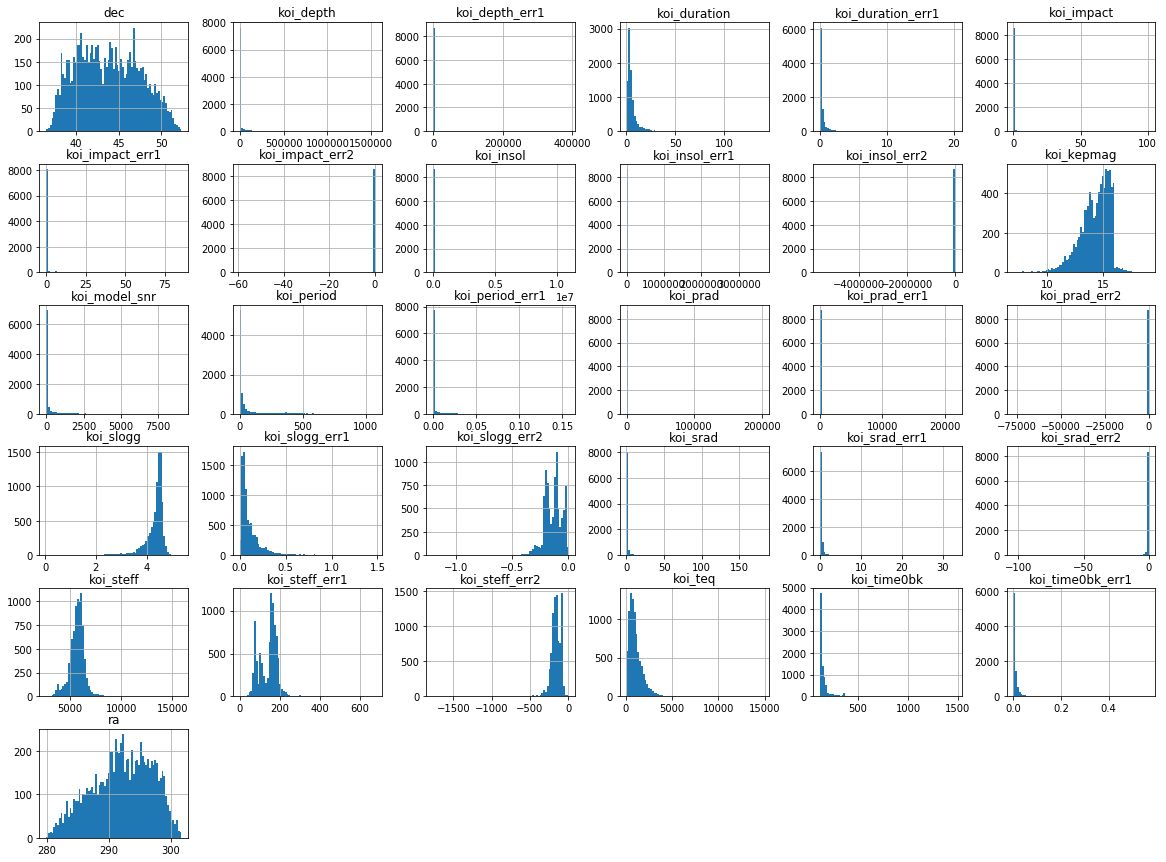

In [135]:
df[koi_dict['num_preds']].hist(bins=75, figsize=(20,15))
plt.show()

We see that some of the variables present in the data have distributions that are extremely skewed (left- or right-) and heavy-tailed.

In [136]:
# Look at the skewness - the standard normal distribution (and any symmetric distribution) has skewness equal to 0
df[koi_dict['num_preds']].skew().sort_values(ascending=False)

koi_depth_err1       90.899397
koi_insol            52.049788
koi_prad             51.049176
koi_insol_err1       49.699199
koi_prad_err1        40.946182
koi_impact           24.549838
koi_srad             19.754525
koi_srad_err1        19.521111
koi_time0bk_err1     11.781813
koi_duration_err1     9.303124
koi_period_err1       8.671389
koi_impact_err1       6.313634
koi_duration          6.143787
koi_depth             5.340706
koi_model_snr         5.195254
koi_time0bk           3.906031
koi_teq               3.453994
koi_slogg_err1        3.022713
koi_period            2.910105
koi_steff_err1        0.800846
koi_steff             0.754341
dec                   0.165078
ra                   -0.288289
koi_kepmag           -0.927862
koi_slogg_err2       -1.638200
koi_slogg            -3.373060
koi_steff_err2       -4.632956
koi_impact_err2     -27.358002
koi_srad_err2       -33.794542
koi_insol_err2      -55.286469
koi_prad_err2       -55.444144
dtype: float64

In [137]:
# Look at the excess kurtosis - a measure of how heavy the tails are.  A standard normal distribution has excess kurtosis equal to 0.
df[koi_dict['num_preds']].kurtosis().sort_values(ascending=False)

koi_depth_err1       8403.689605
koi_insol_err2       3331.133742
koi_prad_err2        3292.414844
koi_insol            3130.849330
koi_insol_err1       3100.682858
koi_prad             2845.925251
koi_prad_err1        1854.809420
koi_srad_err2        1623.144574
koi_impact_err2       968.549388
koi_impact            654.667235
koi_srad_err1         499.304858
koi_srad              471.064267
koi_time0bk_err1      211.196932
koi_duration_err1     171.549900
koi_period_err1       117.681974
koi_steff_err2         75.191407
koi_duration           69.923726
koi_impact_err1        40.354192
koi_depth              39.975494
koi_model_snr          32.934129
koi_time0bk            28.755378
koi_teq                27.934307
koi_slogg              18.408959
koi_slogg_err1         12.447441
koi_slogg_err2         10.668325
koi_period              8.581300
koi_steff               8.080196
koi_steff_err1          7.925103
koi_kepmag              1.302852
ra                     -0.728965
dec       

# Create a Train Test Split
Use `koi_disposition` for the y values



In [138]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, random_state=1, stratify=df.koi_disposition)

# Visualize the Data
The histograms above revealed the skewness and heavy tails present in most of the distributions.  A MinMax scaler will not eliminate the skewness and heavy tails; it will only shift the distribution to a range of 0 to 1, leaving the same skewness and tails present - just over a smaller range.  Other transformations of the predictors such as `log(abs(x)+1)`, `arctan(x)`, and power transformations such as Yeo-Johnson can reduce the skewness and kurtosis.  I considered the first two families of transformations before choosing the Yeo-Johnson family.  The log transformation needed to be iterated three times to bring the skewness to an acceptable level; that is, the form of the transformation was:

>`# log(abs(log(abs(log(abs(x)+1)) + 1)) + 1)`
>
>`def logabsp1 (x):`
>
>>`    return np.log( np.abs(np.log( np.abs(np.log( np.abs(x) + 1 )) + 1 )) + 1 )`

In the following, we will look at the transformed numerical predictors and how they can potentially classify the outcome.

The estimated value of the transformation parameter is 0.13743885156286367


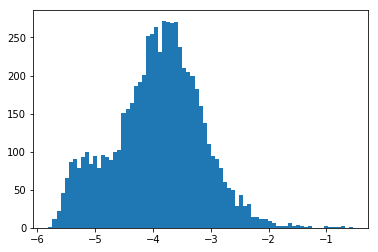

In [139]:
# Let's consider one variable:
from scipy.stats import boxcox, skew, kurtosis
transf_time0bk_err1, lam_  = boxcox(train_set['koi_time0bk_err1'])
print(f"The estimated value of the transformation parameter is {lam_}")
plt.hist(transf_time0bk_err1, bins=75)
plt.show()

In [140]:
# We see that the transformations improve the skewness and kurtosis
print(skew(transf_time0bk_err1), kurtosis(transf_time0bk_err1))

-0.010487096993483793 0.09515725869725733


In [141]:
np.any(train_set['koi_time0bk_err1'] <= 0)

False

{'koi_time0bk_err1': 0.13743885156286367, 'koi_model_snr': -0.3821715489988634, 'koi_kepmag': 4.16342717289737, 'koi_prad_err1': -0.9454690650491312, 'koi_insol_err1': -0.05412925575062393, 'koi_depth_err1': -0.19664119459403456, 'koi_slogg_err1': -8.666039684718244, 'koi_slogg': 6.687841740275974, 'koi_srad_err2': -4.5033556022018395, 'koi_teq': 0.020458006315097487, 'koi_time0bk': -4.462117906196419, 'koi_insol_err2': -0.08335647248209835, 'ra': 9.37796981534648, 'koi_slogg_err2': -2.9055647956857547, 'koi_period_err1': -0.03225986062707252, 'koi_prad': -0.34091316660164994, 'koi_insol': 0.0051019404204168456, 'koi_steff': 0.5367619301222429, 'koi_srad': -0.5409755266504176, 'koi_period': -0.10154545766745113, 'koi_steff_err1': 0.6823098145825282, 'koi_steff_err2': 0.3867447121970126, 'koi_duration_err1': -3.3604473962552857, 'koi_impact_err1': -2.1589798225100467, 'koi_duration': -0.15466420824157862, 'dec': -0.1037868193928398, 'koi_srad_err1': -2.827551185243323, 'koi_depth': -0.2

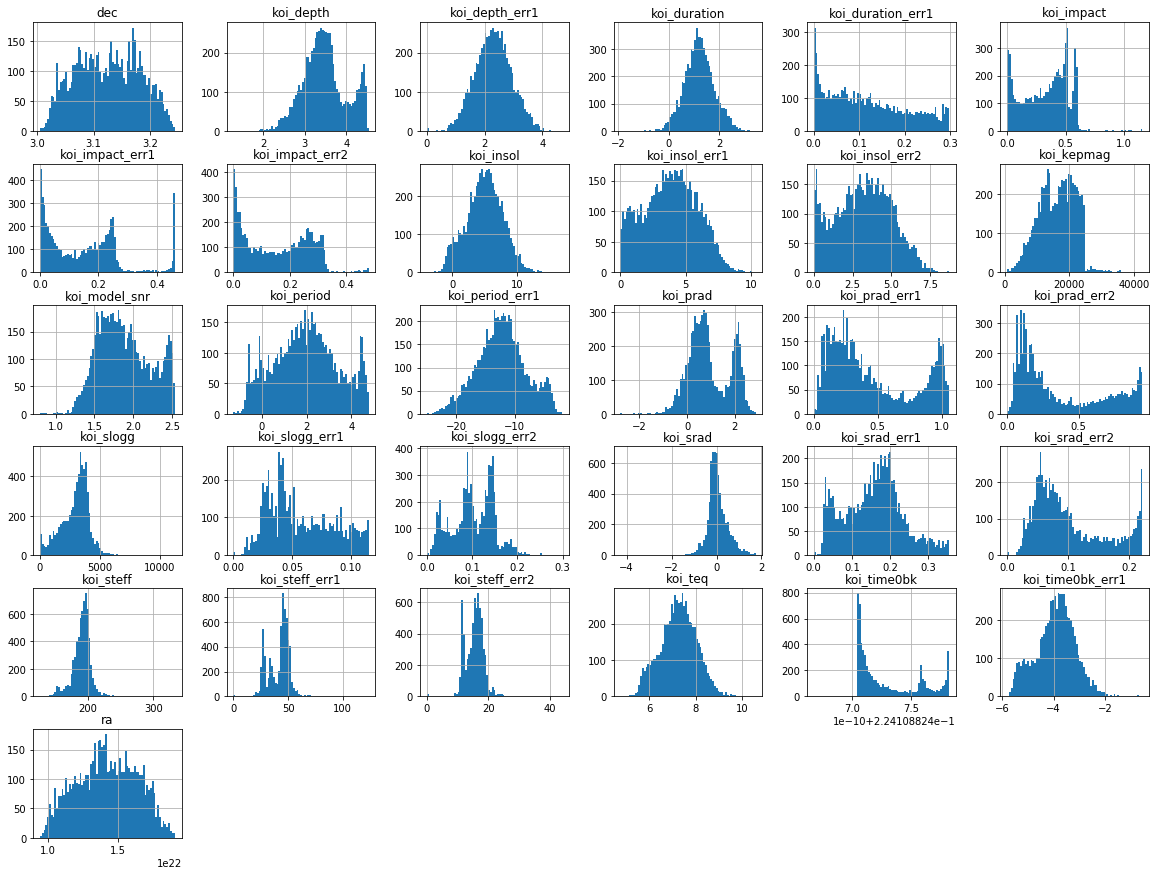

In [142]:
# We will now consider transforming all of the numerical predictors in the training dataframe:
# Note:  The tests for numbers less than or equal to zero are using background knowledge of the dataframes - 
# For example, all variables are either >= 0 or <= 0.  We do not have mixed-sign numbers in this data set.

transf_dict = {}
transf_df = pd.DataFrame()
for col in koi_dict['num_preds']:
    if np.any(train_set[col] == 0.0):
        if np.any(train_set[col] < 0):
            transf, power = boxcox(-train_set[col] + 1)
        else:
            transf, power = boxcox(train_set[col] + 1)
    elif np.any(train_set[col] < 0):
        transf, power = boxcox(-train_set[col])
    else:
         transf, power = boxcox(train_set[col])
    transf_dict[col] = power
    transf_df[col] = transf
    
print(transf_dict)
transf_df.hist(bins=75, figsize=(20,15))
plt.show()

We see that the skewness and kurtosis are reduced greatly by the Box-Cox transformations used above.
There is also evidence of multi-modality in the distributions that was easily seen before.  We compute the skewness and kurtosis for the transformed variables below.

In [143]:
transf_df.skew().sort_values(ascending=False)

koi_impact_err1      0.810841
koi_srad_err2        0.798139
koi_prad_err2        0.686592
koi_prad_err1        0.584771
koi_duration_err1    0.440664
koi_slogg_err1       0.420655
koi_steff_err2       0.310981
koi_model_snr        0.235400
koi_prad             0.211945
koi_impact_err2      0.169896
koi_srad_err1        0.149533
koi_steff_err1       0.140669
koi_steff            0.109769
koi_depth            0.105133
koi_insol_err2       0.050775
koi_period           0.049627
koi_insol_err1       0.033130
koi_period_err1      0.009455
koi_depth_err1       0.008989
dec                  0.002835
koi_slogg_err2       0.001141
koi_time0bk          0.000000
koi_teq             -0.000356
koi_insol           -0.000357
koi_time0bk_err1    -0.010489
koi_duration        -0.013783
koi_impact          -0.028915
ra                  -0.044140
koi_kepmag          -0.065195
koi_slogg           -0.137290
koi_srad            -0.413731
dtype: float64

In [144]:
transf_df.kurtosis().sort_values(ascending=False)

koi_srad             7.546497
koi_steff_err2       5.875372
koi_steff            4.909296
koi_steff_err1       3.107573
koi_slogg            1.811116
koi_duration         0.418111
koi_impact_err1      0.156954
koi_time0bk_err1     0.096145
koi_time0bk          0.000000
koi_teq             -0.068520
koi_insol           -0.068928
koi_depth_err1      -0.068933
koi_kepmag          -0.217782
koi_slogg_err2      -0.262184
koi_depth           -0.263097
koi_period_err1     -0.271245
koi_impact          -0.287770
koi_srad_err1       -0.393466
koi_srad_err2       -0.580437
koi_insol_err1      -0.728626
koi_insol_err2      -0.748140
koi_period          -0.780287
koi_model_snr       -0.796338
koi_prad            -0.828247
ra                  -0.846165
koi_duration_err1   -0.939175
koi_slogg_err1      -0.956135
dec                 -0.999641
koi_prad_err2       -1.081856
koi_prad_err1       -1.091739
koi_impact_err2     -1.111432
dtype: float64

In [145]:
# Are there redundant features present in the data?  We can look at the correlation matrix
# of the numerical predictors:
corr_matrix = transf_df.corr()

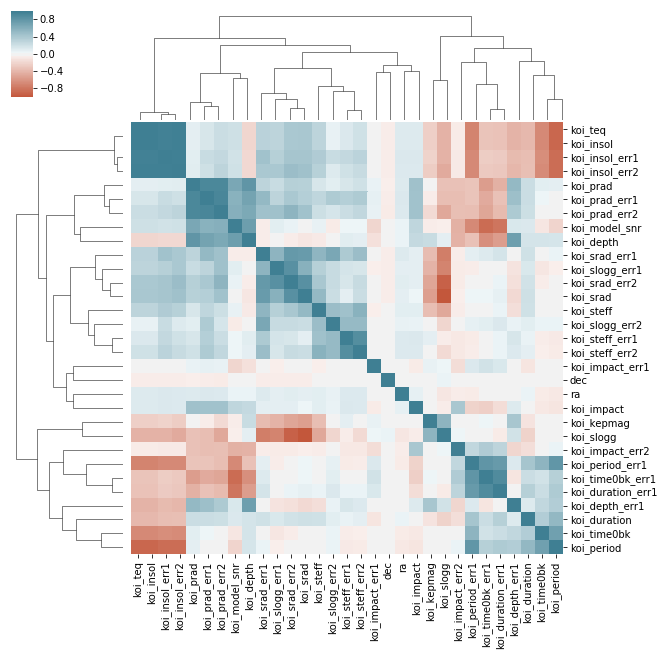

In [146]:
#corr = data.corr()
import seaborn as sns
ax = sns.clustermap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [151]:
print(corr_matrix['koi_teq'].sort_values(ascending=False)[:4])
print(corr_matrix['koi_teq'].sort_values(ascending=True)[:4])
print(corr_matrix['koi_prad'].sort_values(ascending=False)[:6])
print(corr_matrix['koi_impact_err2'].sort_values(ascending=False)[:6])

koi_teq           1.000000
koi_insol         0.999999
koi_insol_err2    0.982948
koi_insol_err1    0.973069
Name: koi_teq, dtype: float64
koi_period        -0.877756
koi_period_err1   -0.708553
koi_time0bk       -0.670885
koi_slogg         -0.406991
Name: koi_teq, dtype: float64
koi_prad          1.000000
koi_prad_err2     0.924048
koi_prad_err1     0.914435
koi_depth         0.806673
koi_model_snr     0.675611
koi_depth_err1    0.518387
Name: koi_prad, dtype: float64
koi_impact_err2      1.000000
koi_impact           0.413778
koi_time0bk_err1     0.367698
koi_duration_err1    0.301491
koi_period_err1      0.284823
koi_period           0.049020
Name: koi_impact_err2, dtype: float64


## Summary
We could further reduce the dimensonality of the predictors by either eliminating highly correlated terms or using a linear combination of the highly correlated terms in their place

# Visualize the Discriminative Value of the Predictors in the Model
We consider plots of the kernel density estimates of the joint distributions for pairs of variables in the model.  The densities are shaded according to the levels of the response.  Separation in the plots would suggest the response could be easily predicted from the pair of predictors.

In [152]:
transf_df['koi_disposition'] = train_set['koi_disposition']

In [153]:
def kde_plot_pairs(df, var1, var2):
    # Subset the transformed dataset by koi_disposition
    confirmed = df.query("koi_disposition == 'CONFIRMED'")
    falsep = df.query("koi_disposition == 'FALSE POSITIVE'")
    candidate = df.query("koi_disposition == 'CANDIDATE'")

    # Set up the figure
    f, ax = plt.subplots(figsize=(8, 8))
    #ax.set_aspect("equal")

    # Draw the three density plots
    ax = sns.kdeplot(candidate[var1], candidate[var2],
                     cmap="Greens", shade=True, shade_lowest=False)
    ax = sns.kdeplot(confirmed[var1], confirmed[var2],
                     cmap="Blues", shade=True, shade_lowest=False)
    ax = sns.kdeplot(falsep[var1], falsep[var2],
                     cmap="Reds", shade=True, shade_lowest=False)
    
    
    return f, ax


C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(-2, 4.0, 'Candidate')

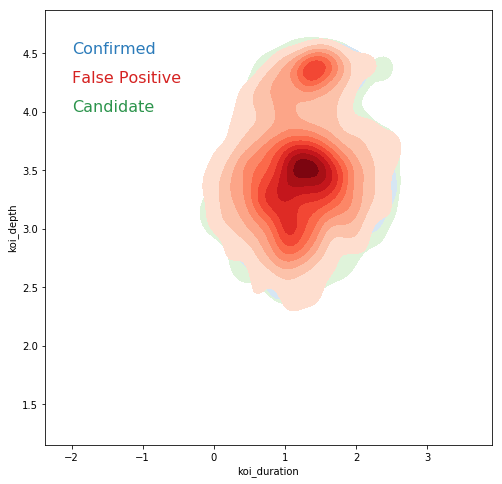

In [154]:
f, ax = kde_plot_pairs(transf_df, 'koi_duration', 'koi_depth')
#Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(-2, 4.5, "Confirmed", size=16, color=blue)
ax.text(-2, 4.25, "False Positive", size=16, color=red)
ax.text(-2, 4.0, "Candidate", size=16, color=green)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24aab80c390>)

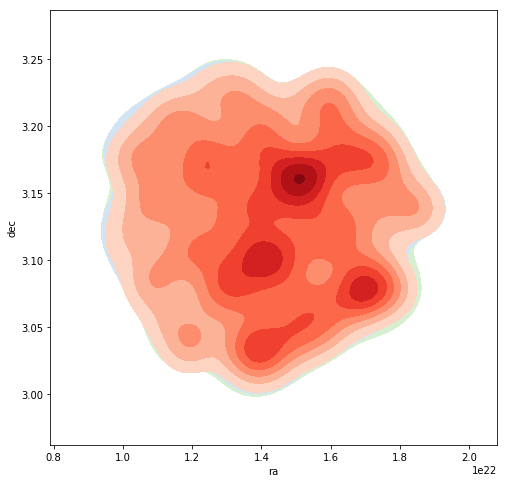

In [155]:
kde_plot_pairs(transf_df, 'ra', 'dec')

Text(30000, -4, 'Candidate')

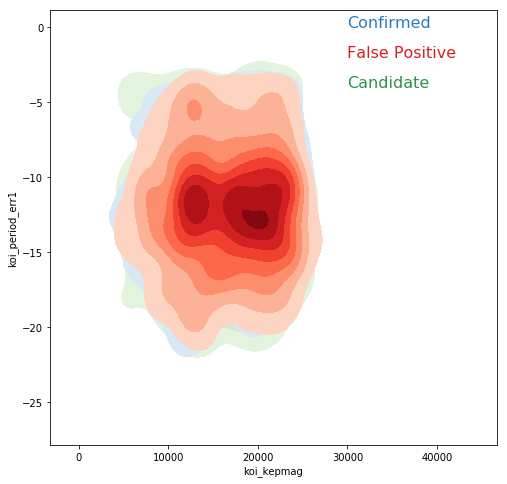

In [156]:
f, ax = kde_plot_pairs(transf_df, 'koi_kepmag', 'koi_period_err1')
#Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(30000, 0, "Confirmed", size=16, color=blue)
ax.text(30000, -2, "False Positive", size=16, color=red)
ax.text(30000, -4, "Candidate", size=16, color=green)

Text(1.5, 3.0, 'Candidate')

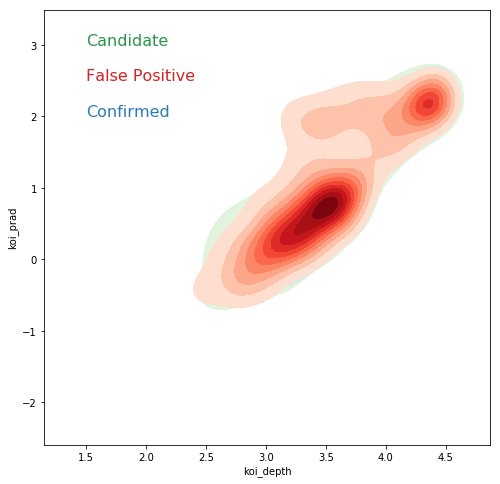

In [157]:
f, ax = kde_plot_pairs(transf_df, 'koi_depth', 'koi_prad')
#Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(1.5, 2.0, "Confirmed", size=16, color=blue)
ax.text(1.5, 2.5, "False Positive", size=16, color=red)
ax.text(1.5, 3.0, "Candidate", size=16, color=green)

In [160]:
from scipy.special import comb
#print("The number of plots we would need to consider with pairs plotting: ", comb(31, 4))
print("The number of plots we would need to consider with kde plotting: ", comb(31, 2))

The number of plots we would need to consider with kde plotting:  465.0


## Summary
We have only considered a few of the kde plots; there are 465 possible plots that could be produced as above.  Of the few we have considered, there is considerable overlap within the classes suggesting that predicting class membership will be difficult.

In the following section, we look at another method of visualizing separation of the response classes by the predictors.  We look at scatterplot matrices with the points shaded by the response value.

In [161]:
def plot_groups_of_four(df, list_of_four, response):
    # list_of_four.append(response)
    print(list_of_four)
    ax = sns.pairplot(df, vars=list_of_four, hue=response)
    plt.show()
    return ax


['koi_period', 'koi_depth_err1', 'koi_model_snr', 'koi_duration']


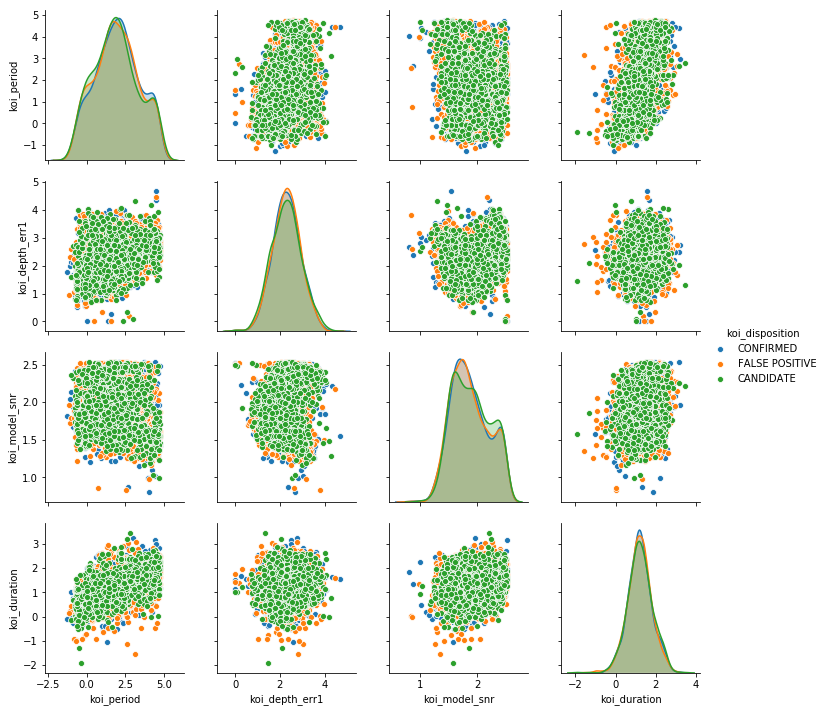

In [162]:
plot_groups_of_four(transf_df, ['koi_period', 'koi_depth_err1', 'koi_model_snr', 'koi_duration'], 'koi_disposition')

['koi_insol', 'koi_steff_err1', 'koi_duration_err1', 'koi_insol_err1']


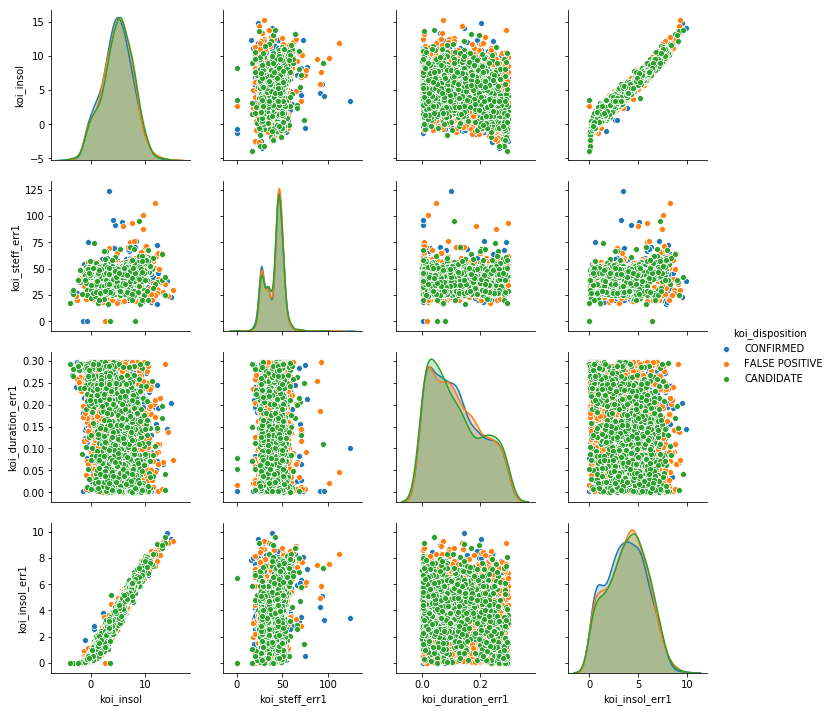

In [163]:
plot_groups_of_four(transf_df, ['koi_insol', 'koi_steff_err1', 'koi_duration_err1', 'koi_insol_err1'], 'koi_disposition')

In [171]:
def plot_groups(df, response):
    # select groups of four from the list of df columns
    cols = df.columns.tolist()
    print(cols)
    for i in range(0,31,4):
        #subset = [i + j for j in range(4)]
        #print(subset)
        if i < 28:
            subset_cols = cols[i:(i+4)]
        else:
            subset_cols = cols[i:(i+3)]
        #print(subset_cols)
        plot_groups_of_four(df, subset_cols, response)
        plt.show()


['koi_time0bk_err1', 'koi_model_snr', 'koi_kepmag', 'koi_prad_err1', 'koi_insol_err1', 'koi_depth_err1', 'koi_slogg_err1', 'koi_slogg', 'koi_srad_err2', 'koi_teq', 'koi_time0bk', 'koi_insol_err2', 'ra', 'koi_slogg_err2', 'koi_period_err1', 'koi_prad', 'koi_insol', 'koi_steff', 'koi_srad', 'koi_period', 'koi_steff_err1', 'koi_steff_err2', 'koi_duration_err1', 'koi_impact_err1', 'koi_duration', 'dec', 'koi_srad_err1', 'koi_depth', 'koi_impact', 'koi_prad_err2', 'koi_impact_err2', 'koi_disposition']
['koi_time0bk_err1', 'koi_model_snr', 'koi_kepmag', 'koi_prad_err1']


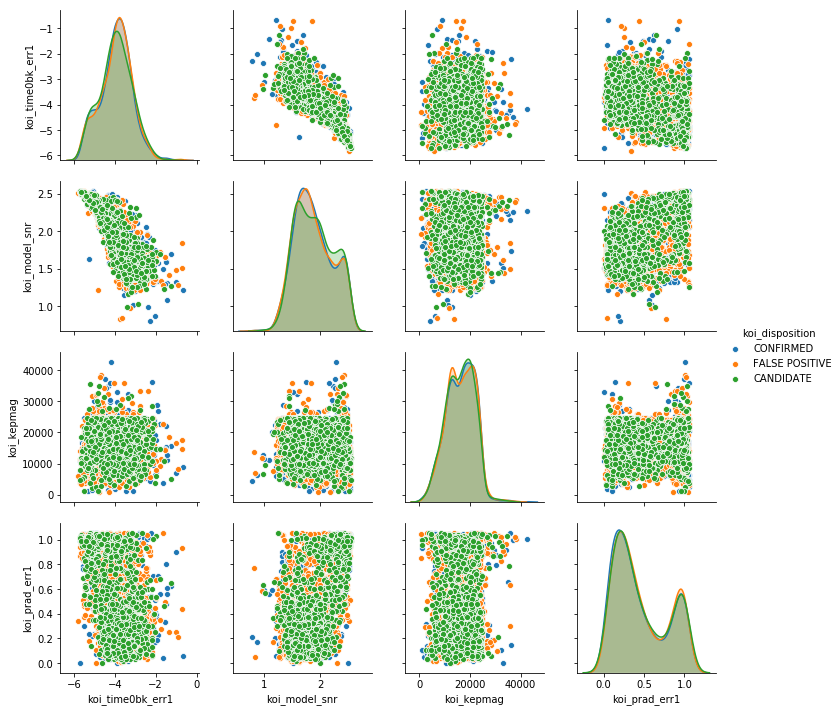

['koi_insol_err1', 'koi_depth_err1', 'koi_slogg_err1', 'koi_slogg']


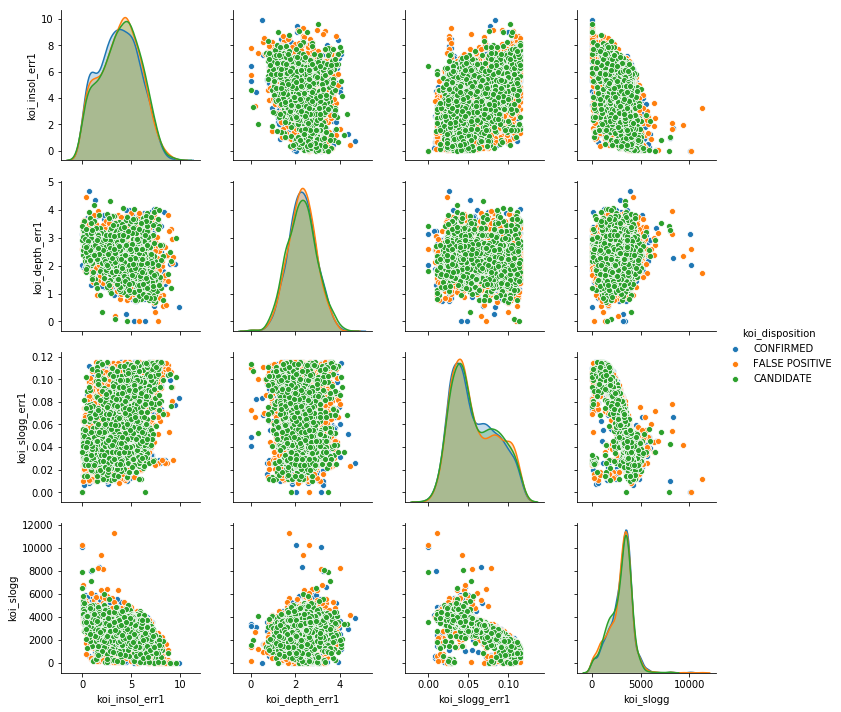

['koi_srad_err2', 'koi_teq', 'koi_time0bk', 'koi_insol_err2']


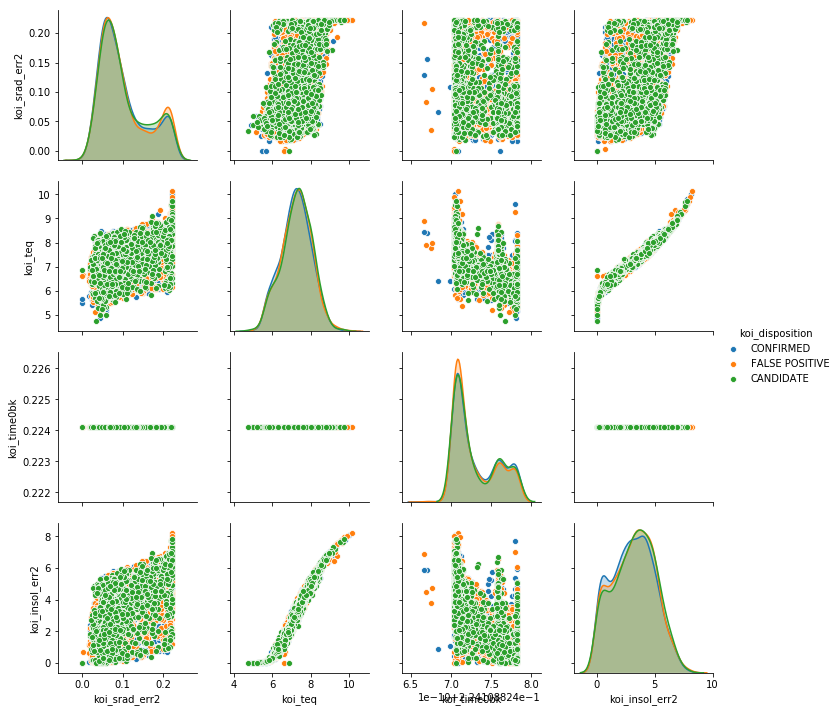

['ra', 'koi_slogg_err2', 'koi_period_err1', 'koi_prad']


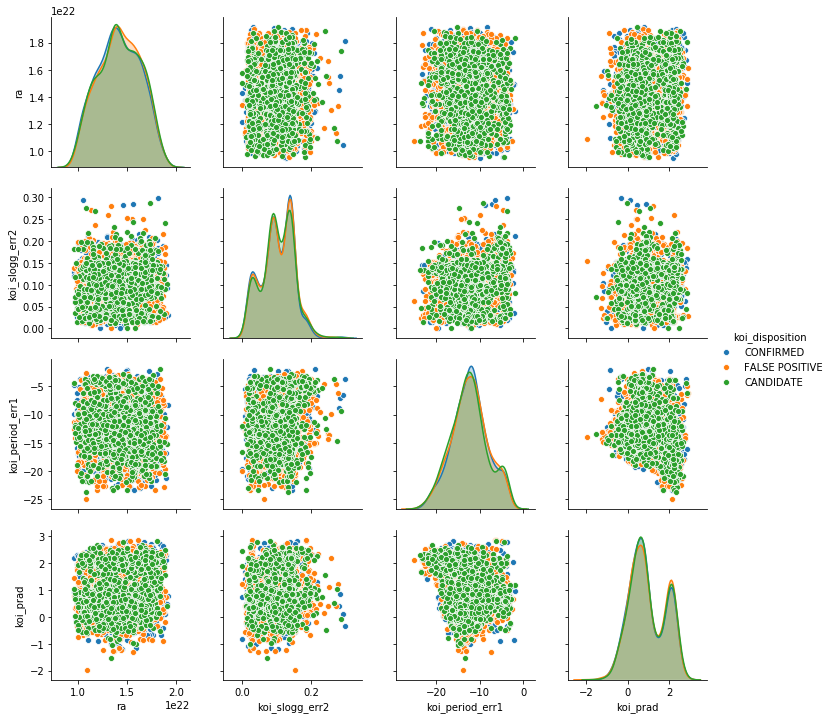

['koi_insol', 'koi_steff', 'koi_srad', 'koi_period']


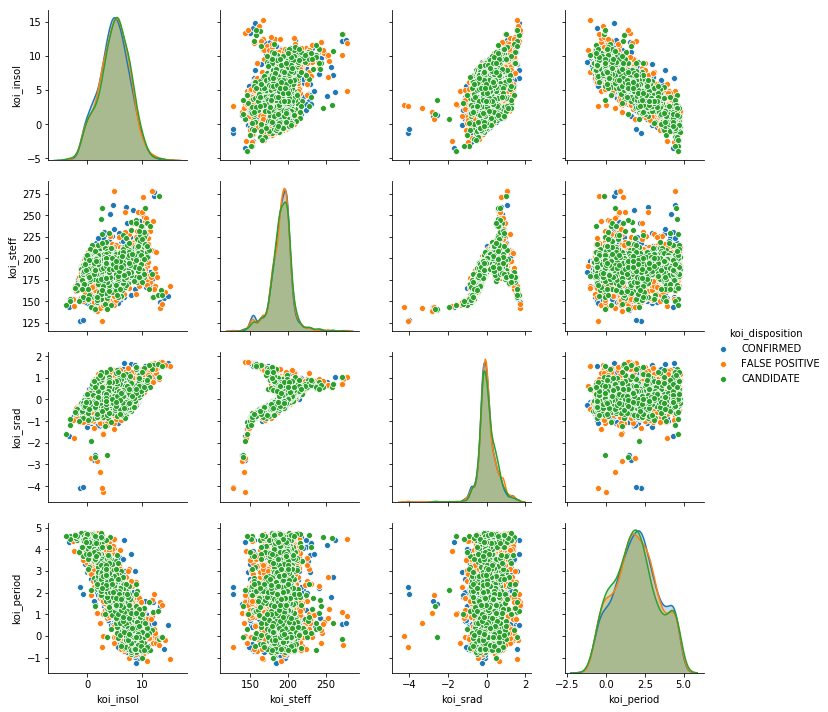

['koi_steff_err1', 'koi_steff_err2', 'koi_duration_err1', 'koi_impact_err1']


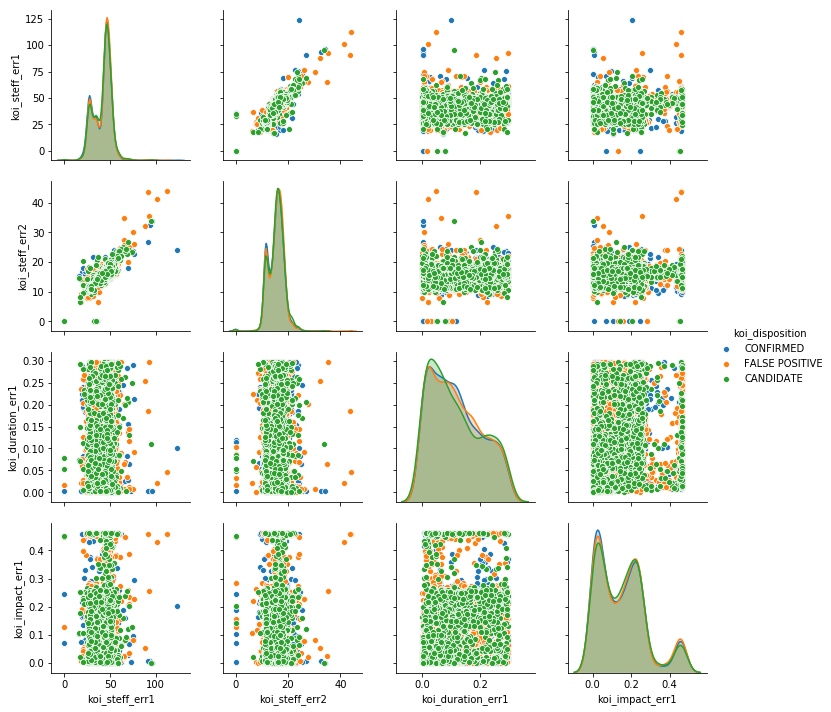

['koi_duration', 'dec', 'koi_srad_err1', 'koi_depth']


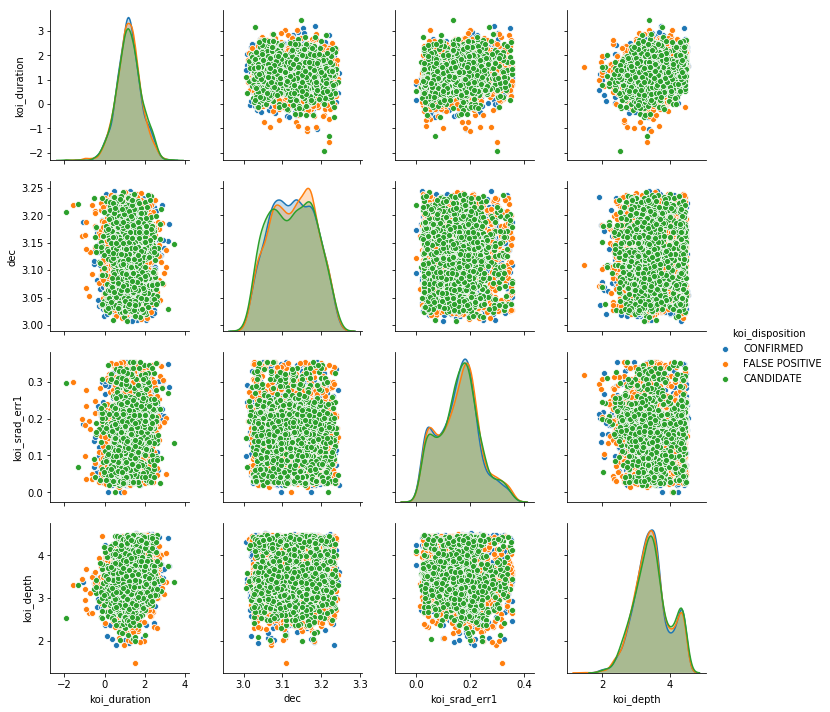

['koi_impact', 'koi_prad_err2', 'koi_impact_err2']


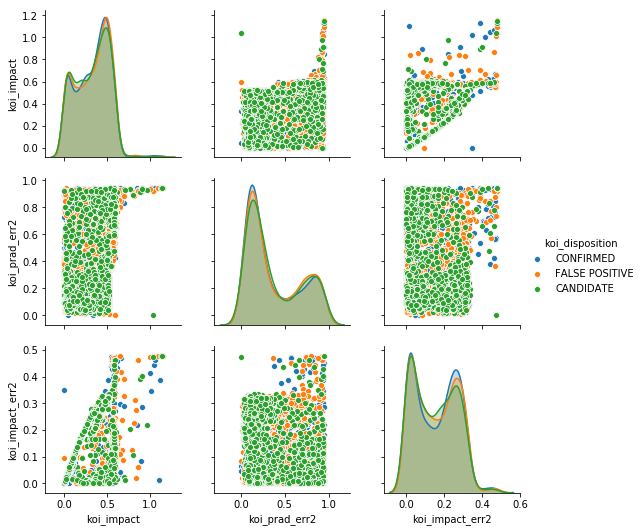

In [172]:
plot_groups(transf_df, 'koi_disposition')

## Summary
Like the kde plots above, these plots look at pairwise distributions of the predictors.  Each of the plots suggests that there is considerable overlap among the predictor distributions within each class.  No single predictor or pair of predictors will successfully classify the response.

# Transformation Pipelines
Scikit-Learn contains standard transformers and methods to build custom transformers.  Each of these can be built into a Pipeline that peforms the necessary steps as part of the ML process

In [181]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# Define a method to select attributes from a DataFrame
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# All of the categorical attributes are 0-1 variates
# For the moment, we will treat koi_tce_plnt_num as a discrete, numerical variable
# We group it with the categorical attributes to avoid scaling it - it is not necessary for its range
num_attribs = koi_dict['num_preds']
cat_attribs = koi_dict['cat_preds']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('power_transf', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('minmax_scaler', MinMaxScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

# Prepare the training data with the pipeline above
X_train_prepared = full_pipeline.fit_transform(train_set)
X_train_prepared

array([[0.97878725, 0.2547893 , 0.55452108, ..., 1.        , 0.        ,
        0.        ],
       [0.93031948, 0.50574772, 0.29458533, ..., 1.        , 0.        ,
        0.        ],
       [0.62332781, 0.42073281, 0.43301702, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.22481604, 0.71306256, 0.42816249, ..., 0.        , 0.        ,
        0.        ],
       [0.8641549 , 0.37738245, 0.33722612, ..., 1.        , 0.        ,
        0.        ],
       [0.17837806, 0.52749203, 0.42642965, ..., 0.        , 0.        ,
        0.        ]])

In [182]:
X_train_prepared.shape

(6558, 36)

In [185]:
y_train = train_set['koi_disposition']

# Train the Support Vector Machine

In [187]:
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train_prepared, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [192]:
X_test_prepared = full_pipeline.fit_transform(test_set)
y_test = test_set['koi_disposition']

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\preprocessing\data.py:2778: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [193]:
X_test_prepared

array([[0.68816534, 0.45961089, 0.40613574, ..., 1.        , 0.        ,
        0.        ],
       [0.45488217, 0.54934581, 0.35803863, ..., 0.        , 0.        ,
        0.        ],
       [0.07568272, 0.71580655, 0.41412604, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.1416672 , 0.60883964, 0.4111306 , ..., 0.        , 0.        ,
        0.        ],
       [0.16033265, 0.61539168, 0.06762132, ..., 0.        , 1.        ,
        0.        ],
       [0.14445873, 0.76619354, 0.38320059, ..., 0.        , 0.        ,
        0.        ]])

In [194]:
print(f"Training Data Score: {model.score(X_train_prepared, y_train)}")
print(f"Testing Data Score: {model.score(X_test_prepared, y_test)}")

Training Data Score: 0.902714242146996
Testing Data Score: 0.8924977127172918


# Error Analysis
We can use the classification report to summarize the predictive ability of the fitted model on the test data. 

I have used the code on page 99 of "Hands-On Machine Learning with Scikit-Learn and TensorFlow" by Aurelien Geron to produce a confusion matrix.  We can observe where the errors are occuring by looking at the confusion matrix; each row is the actual class and each column is the predicted class.  The matrix was modified to have a zero diagonal so as to focus on the errors.

In [204]:
from sklearn.metrics import classification_report
y_test_pred = model.predict(X_test_prepared)
print(classification_report(y_test, y_test_pred, target_names=model.classes_))

                precision    recall  f1-score   support

     CANDIDATE       0.86      0.70      0.77       528
     CONFIRMED       0.76      0.87      0.81       568
FALSE POSITIVE       0.98      1.00      0.99      1090

     micro avg       0.89      0.89      0.89      2186
     macro avg       0.87      0.86      0.86      2186
  weighted avg       0.90      0.89      0.89      2186



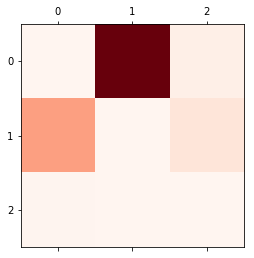

['CANDIDATE' 'CONFIRMED' 'FALSE POSITIVE']


In [205]:
from sklearn.metrics import confusion_matrix
y_test_pred = model.predict(X_test_prepared)
conf_mx = confusion_matrix(y_test, y_test_pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap='Reds')
plt.show()
print(model.classes_)

## Summary
We see that the most errors are occuring with `CANDIDATE` being classified as `CONFIRMED`; the second most frequent error is with the `CONFIRMED` being classified as a `CANDIDATE`.  When we look back at the kde plots and scatterplot matrices, this is not surprising given the amount of overlap present in the data.  The predictor distributions for these two classes often are nested within each other making selecting a decision boundary difficult.

# Hyperparameter Tuning

Use `GridSearchCV` to tune the `C` and `gamma` parameters

In [206]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, verbose=3)

In [207]:
# Train the model with GridSearch
grid.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=1, gamma=0.0001 ...............................................
[CV] ...... C=1, gamma=0.0001, score=0.8948331047096479, total=   0.3s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ...... C=1, gamma=0.0001, score=0.9075937785910339, total=   0.2s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV] ...... C=1, gamma=0.0001, score=0.8997711670480549, total=   0.2s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ...... C=1, gamma=0.0005, score=0.8948331047096479, total=   0.2s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ...... C=1, gamma=0.0005, score=0.9075937785910339, total=   0.2s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ...... C=1, gamma=0.0005, score=0.8997711670480549, total=   0.2s
[CV] C=1, gamma=0.001 ................................................
[CV] ....... C=1, gamma=0.001, score=0.8948331047096479, total=   0.2s
[CV] C=1, gamma=0.001 ................................................
[CV] ....... C=1, gamma=0.001, score=0.9075937785910339, total=   0.2s
[CV] C=1, gamma=0.001 ................................................
[CV] ....... C=1, gamma=0.001, score=0.8997711670480549, total=   0.2s
[CV] C=1, gamma=0.005 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   25.5s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 10, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [208]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 1, 'gamma': 0.0001}
0.9007319304666057


In [210]:
grid.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Treating the kernel as a hyperparameter
The kernel used by a support-vector classifier can be selected for more flexibility in fitting; polynomial and radial-basis function kernels permit non-linear boundaries in the original feature space by enlarging the feature space to include higher-order terms of the original features.  Non-linear classification boundaries can improve accuracy; however, if the boundary is too irregular and fit to the specific training data, we may not generalize well to new data.

In [212]:
# Create the GridSearchCV model
param_grid = {'C': [1, 5, 10, 50],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid2 = GridSearchCV(model, param_grid, verbose=3)

In [213]:
# Train the model with GridSearch
grid2.fit(X_train_prepared, y_train)

C:\Users\dadra\anaconda\Anaconda3\envs\PythonWebMongo\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV]  C=1, gamma=0.0001, kernel=linear, score=0.8948331047096479, total=   0.2s
[CV] C=1, gamma=0.0001, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  C=1, gamma=0.0001, kernel=linear, score=0.9075937785910339, total=   0.2s
[CV] C=1, gamma=0.0001, kernel=linear ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  C=1, gamma=0.0001, kernel=linear, score=0.8997711670480549, total=   0.2s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV]  C=1, gamma=0.0001, kernel=poly, score=0.4983996342021033, total=   0.9s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV]  C=1, gamma=0.0001, kernel=poly, score=0.49817017383348583, total=   0.9s
[CV] C=1, gamma=0.0001, kernel=poly ..................................
[CV]  C=1, gamma=0.0001, kernel=poly, score=0.4983981693363844, total=   0.9s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.4983996342021033, total=   1.2s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.49817017383348583, total=   1.2s
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV]  C=1, gamma=0.0001, kernel=rbf, score=0.4983981693363844, total=   1.2s
[CV] C=1, gamma=0.0001, ker

[CV]  C=5, gamma=0.0001, kernel=sigmoid, score=0.4997713763145862, total=   1.1s
[CV] C=5, gamma=0.0001, kernel=sigmoid ...............................
[CV]  C=5, gamma=0.0001, kernel=sigmoid, score=0.4986276303751144, total=   1.1s
[CV] C=5, gamma=0.0001, kernel=sigmoid ...............................
[CV]  C=5, gamma=0.0001, kernel=sigmoid, score=0.4997711670480549, total=   1.1s
[CV] C=5, gamma=0.0005, kernel=linear ................................
[CV]  C=5, gamma=0.0005, kernel=linear, score=0.8943758573388203, total=   0.2s
[CV] C=5, gamma=0.0005, kernel=linear ................................
[CV]  C=5, gamma=0.0005, kernel=linear, score=0.9048490393412626, total=   0.2s
[CV] C=5, gamma=0.0005, kernel=linear ................................
[CV]  C=5, gamma=0.0005, kernel=linear, score=0.9002288329519451, total=   0.2s
[CV] C=5, gamma=0.0005, kernel=poly ..................................
[CV]  C=5, gamma=0.0005, kernel=poly, score=0.4983996342021033, total=   0.9s
[CV] C=5, gam

[CV]  C=10, gamma=0.0005, kernel=poly, score=0.49817017383348583, total=   0.9s
[CV] C=10, gamma=0.0005, kernel=poly .................................
[CV]  C=10, gamma=0.0005, kernel=poly, score=0.4983981693363844, total=   0.9s
[CV] C=10, gamma=0.0005, kernel=rbf ..................................
[CV]  C=10, gamma=0.0005, kernel=rbf, score=0.8500228623685414, total=   0.8s
[CV] C=10, gamma=0.0005, kernel=rbf ..................................
[CV]  C=10, gamma=0.0005, kernel=rbf, score=0.8604757548032936, total=   0.8s
[CV] C=10, gamma=0.0005, kernel=rbf ..................................
[CV]  C=10, gamma=0.0005, kernel=rbf, score=0.851258581235698, total=   0.8s
[CV] C=10, gamma=0.0005, kernel=sigmoid ..............................
[CV]  C=10, gamma=0.0005, kernel=sigmoid, score=0.8459076360310929, total=   0.9s
[CV] C=10, gamma=0.0005, kernel=sigmoid ..............................
[CV]  C=10, gamma=0.0005, kernel=sigmoid, score=0.8522415370539799, total=   0.9s
[CV] C=10, gamma=0

[CV]  C=50, gamma=0.0005, kernel=sigmoid, score=0.8764302059496567, total=   0.5s
[CV] C=50, gamma=0.001, kernel=linear ................................
[CV]  C=50, gamma=0.001, kernel=linear, score=0.8930041152263375, total=   0.4s
[CV] C=50, gamma=0.001, kernel=linear ................................
[CV]  C=50, gamma=0.001, kernel=linear, score=0.909423604757548, total=   0.4s
[CV] C=50, gamma=0.001, kernel=linear ................................
[CV]  C=50, gamma=0.001, kernel=linear, score=0.8997711670480549, total=   0.5s
[CV] C=50, gamma=0.001, kernel=poly ..................................
[CV]  C=50, gamma=0.001, kernel=poly, score=0.4983996342021033, total=   0.9s
[CV] C=50, gamma=0.001, kernel=poly ..................................
[CV]  C=50, gamma=0.001, kernel=poly, score=0.49817017383348583, total=   0.9s
[CV] C=50, gamma=0.001, kernel=poly ..................................
[CV]  C=50, gamma=0.001, kernel=poly, score=0.4983981693363844, total=   0.9s
[CV] C=50, gamma=0

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  3.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 5, 10, 50], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [0.0001, 0.0005, 0.001, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [215]:
print(grid2.best_params_)
print(grid2.best_score_)

{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.9007319304666057


# Summary
We see that the added flexibility of the radial-basis and polynomial features do not significantly improve upon the best fit model using a linear kernel.